У нас есть набор фотографий людей. Для каждой фотографии указан возраст изображённых на них людей. Необходимо построить модель, которая будет определять возраст человека по его фотографии.

- Сначала проведём исследовательский анализ данных. Прямо скажем, анализировать придётся немного
- Затем обучим модель на GPU
- В конце оценим, насколько хорошо модель справилась с заданием

# 1. Исследовательский анализ данных

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
sns.set()

Функция `column_info` показывает информацию по столбцу.

In [4]:
def column_info(data, column, quantitative=False, mean=True, median=True, hist=True, bins=50):    
    lost = data[column].isna().sum() #смотрим количество пропусков
    total = data.shape[0] #длина всех значений переменной
    print()
    print('*** Информация по столбцу {} ***'.format(column))
    print()
    print('Тип данных столбца {}: {}:'.format(column, data[column].dtype))
    print('В столбце {} пропущено {} из {} строк, что составляет {:.2%}'
          .format(column, lost, total, lost / total)) #считаем процент пропусков
    if quantitative:        
        print('Минимальное значение: {:.2f}'.format(data[column].min()))
        print('Максимальное значение: {:.2f}'.format(data[column].max()))
        if mean:
            print('Среднее значение: {:.2f}'.format(data[column].mean()))
        if median:
            print('Медианное значение: {:.2f}'.format(data[column].median()))
        if hist:
            gridsize = (5, 1)
            fig = plt.figure(figsize=(15, 5))
            ax1 = plt.subplot2grid(gridsize, (0, 0))
            ax2 = plt.subplot2grid(gridsize, (1, 0), rowspan=4)                       
            sns.boxplot(data[column], ax=ax1)            
            sns.distplot(data[column], kde=False, bins=bins, ax=ax2)            
            ax1.get_xaxis().set_visible(False)            
            plt.show()                        
    else:
        print()
        print('Количество значений в каждой из категорий:')
        print(data[column].value_counts())        
    print()

Загружаем метки традиционным методом pandas. А картинки загружаем динамически с помощью загрузчика `ImageDataGenerator`.

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1/255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=21)

Found 7591 validated image filenames.


В нашем распоряжении 7 591 картинка. Для данной задачи это немного. Больше - лучше. Можно судить по конечному результату: погрешность в 7 лет - довольно-таки большая. Очевидно, её можно уменьшать большим количеством данных. Ну и ответ на этот вопрос сильно зависит от возрастной группы, например, для лиц 85+ у нас совсем мало данных.

Посмотрим распределение возрастов.

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB



*** Информация по столбцу real_age ***

Тип данных столбца real_age: int64:
В столбце real_age пропущено 0 из 7591 строк, что составляет 0.00%
Минимальное значение: 1.00
Максимальное значение: 100.00
Среднее значение: 31.20
Медианное значение: 29.00


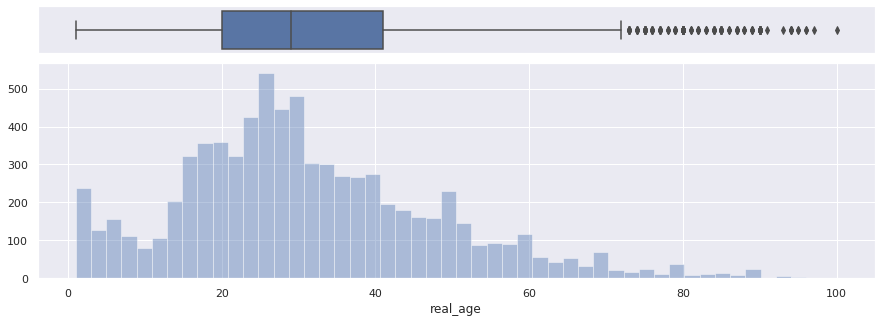

In [7]:
column_info(labels, 'real_age', quantitative=True)

Видим нормальное распределение, скошенное вправо. На нормальность распределения указывает также и то, что медиана близка к среднему. Справа есть технические вбросы: людей, преодолевших 85 лет мало в сравнении с общим количеством людей. 

Что с этим делать? Для улучшения качества модели можно провести дополнительный апсэмплинг картинок с людьми, старше 85 лет, возможно с помощью поворотов.

Берём 1-й батч.

In [8]:
features, target = next(train_gen_flow)

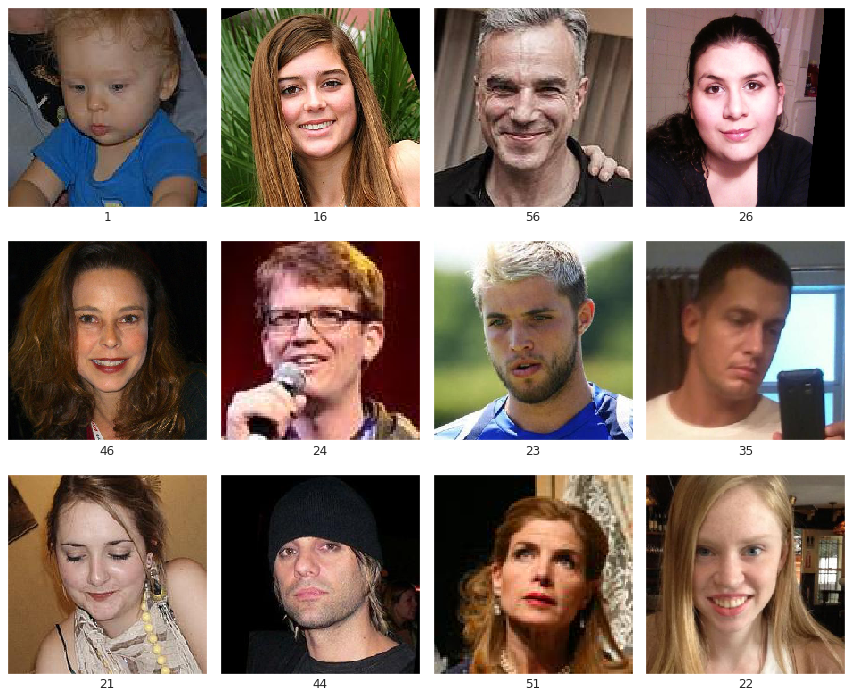

In [9]:
fig = plt.figure(figsize=(12,10))
for i in range(12):
    ax = fig.add_subplot(3, 4, i+1)
    ax.set_xlabel(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Выглядит всё правдоподобно. Хотя для улучшения результатов модели можно проверить этот набор картинок на адекватность, т.е. с помощью нейросети, выянить, на каких картинках изображён не человек и исключить их из набора. 

Исходя из набора данных, можно ожидать, что модель лучше обучится определять людей в возрастной группе 25-35 лет, так как из больше всего в наборе. А вот с лицами за 85 могут быть проблемы.

Посмотрим пару следующих батчей.

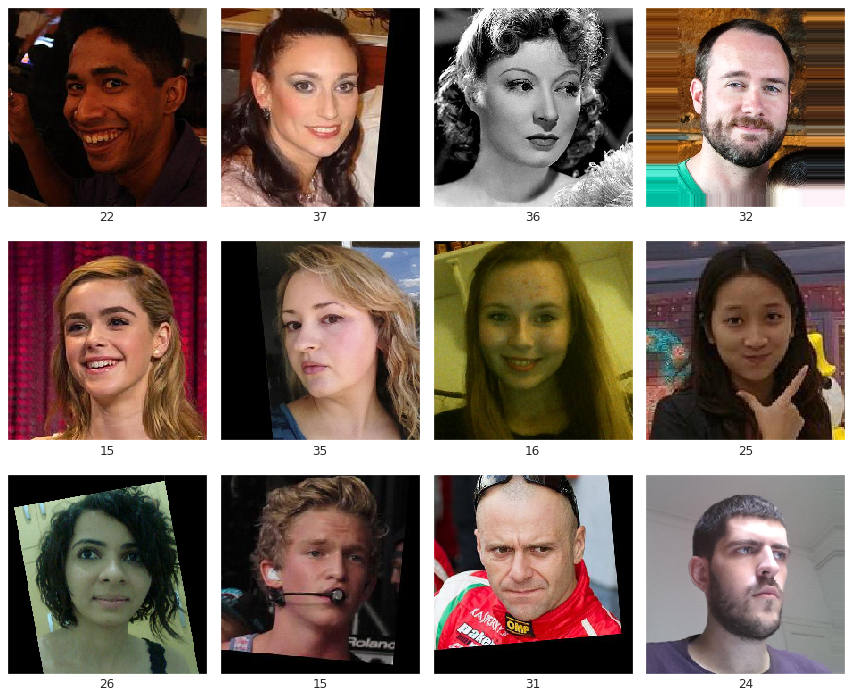

In [10]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(12,10))
for i in range(12):
    ax = fig.add_subplot(3, 4, i+1)
    ax.set_xlabel(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

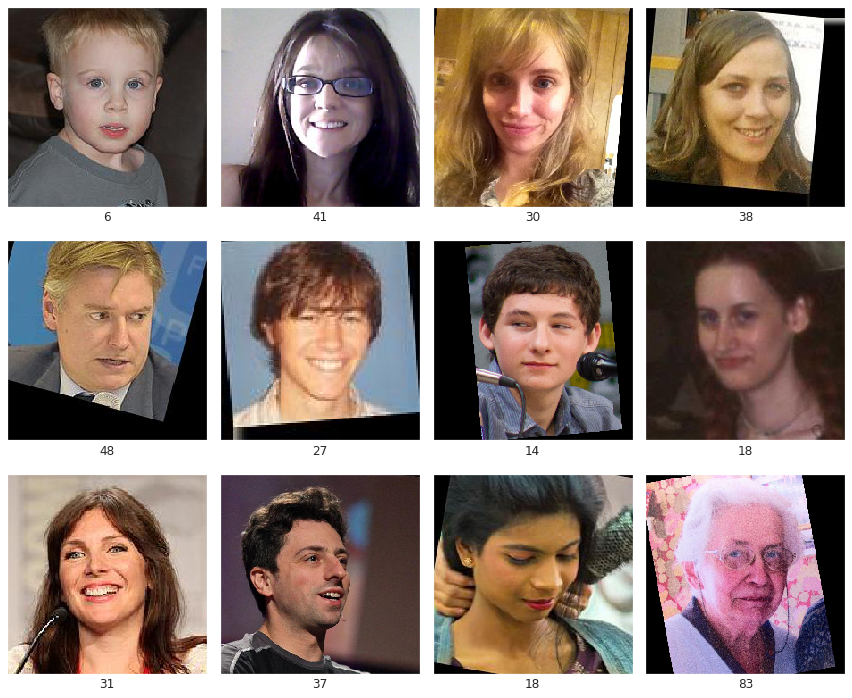

In [11]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(12,10))
for i in range(12):
    ax = fig.add_subplot(3, 4, i+1)
    ax.set_xlabel(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Многие фото повёрнуты, оригинальные фото разного размера, некоторые имеют чёрно-белую рассветку.

# 2. Обучение модели

Разделяем тренировочный и тестовый датасеты в стандартном отношении 3:1. Размер картинки можно оставить изначальным (224, 224) и размер батча=32.

К обучающему набору данных применяем аугментацию, но без поворотов, чтобы сократить вычислительные объёмы.

В качестве архитектуры используем предобученную сеть ResNet50, в качестве оптимизатора - Adam, функция потерть - среднеквадратичное отклонение, метрика - среднее абсолютное отклонение.

```python

import numpy as np
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    
    train_datagen = ImageDataGenerator(
        validation_split=.25,
        rescale=1/255,
        horizontal_flip=True,
        vertical_flip=True,    
        width_shift_range=.2,
        height_shift_range=.2) 
    
    labels = pd.read_csv(path + '/labels.csv')
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw', 
        subset='training',
        seed=21) 
    
    return train_datagen_flow

def load_test(path):
    
    test_datagen = ImageDataGenerator(
        validation_split=.25,
        rescale=1/255)
    
    labels = pd.read_csv(path + '/labels.csv')
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        barch_size=32,
        class_mode='raw',
        subset='validation',
        seed=21)
    
    return test_datagen_flow

def create_model(input_shape):
    
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet', 
        include_top=False)
    
    model = Sequential()
    
    model.add(backbone)    
    model.add(GlobalAveragePooling2D())       
    model.add(Dense(1, activation='relu'))   
    
    optimizer = Adam(lr=.00001)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=32, epochs=10, steps_per_epoch=None, validation_steps=None):    
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,              
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)
    
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 60 steps
Epoch 1/5
356/356 - 164s - loss: 312.9570 - mae: 13.1017 - val_loss: 949.4807 - val_mae: 26.0875
Epoch 2/5
356/356 - 67s - loss: 135.0599 - mae: 8.9000 - val_loss: 241.8038 - val_mae: 11.6561
Epoch 3/5
356/356 - 64s - loss: 112.6545 - mae: 8.1607 - val_loss: 118.7277 - val_mae: 8.1722
Epoch 4/5
356/356 - 64s - loss: 98.7123 - mae: 7.5906 - val_loss: 132.6345 - val_mae: 8.7070
Epoch 5/5
356/356 - 64s - loss: 90.4847 - mae: 7.3123 - val_loss: 96.6201 - val_mae: 7.1953

60/60 - 9s - loss: 96.6201 - mae: 7.1953
Test MAE: 7.1953

```

На последней эпохе было достигнута необхадимая метрика, причём модель не переобучилась, метрики на обучающем и тестовом наборе примерно равны.

# 3. Анализ обученной модели

Был применён весь арсенал инструментов и подходов из тренажёра: потоковая загрузка данных, оптимизатор Adam, аугментация, предобученная нейронная сеть ResNet50. Всё это позволило достичь метрики mae = 7.2. В целом это означает, что модель ошибается на 7.2 года в своей оценке возраста по фотографии. 

Много это или мало? Зависит от возраста. Чем больше возраст, тем погрешность менее значительна. Поэтому целесообразно для дальнейшего исследования посмотреть, как модель справляется в отдельных возрастных категориях. 